In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm
import numpy as np
import cv2

import os

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras import backend as K


def jaccard_distance(y_true, y_pred, smooth=100):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# model_path = 'ready_models/cube_combo_50'

# model = tf.keras.models.load_model(filepath=model_path,compile=False)
# model.compile(optimizer='adam',
#               loss=jaccard_distance,
#               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, f1_score])

In [106]:
def get_model(path):
    model = tf.keras.models.load_model(filepath=path,compile=False)
    model.compile(optimizer='adam',
              loss=jaccard_distance,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, f1_score])
    print()
    print(path,'ready')
    return model

In [146]:
model_path_orig = 'ready_models/sofa_real'
model_path_synt = 'ready_models/boost_sofa_5'
model_path_combo = 'ready_models/sofa_combo'

model_orig = get_model(model_path_orig)
model_synt = get_model(model_path_synt)
model_combo = get_model(model_path_combo)



ready_models/sofa_real ready

ready_models/boost_sofa_5 ready

ready_models/sofa_combo ready


In [147]:
# eval_obj_path = 'Cube/orig/'
# eval_obj_path = 'dual/'
eval_obj_path = 'sofa_5/'

In [148]:
# IMG_HEIGHT, IMG_WIDTH = model.get_config()['layers'][0]['config']['batch_input_shape'][1:3]
IMG_HEIGHT, IMG_WIDTH = 128,128
eval_image_dataset = np.array([
    cv2.resize(cv2.imread(f'{eval_obj_path}image_for_test_dg/images/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    for file in tqdm(os.listdir(f'{eval_obj_path}image_for_test_dg/images/'))])

# eval_mask_dataset = np.array([
#     np.expand_dims(
#         cv2.resize(
#             cv2.imread(f'{eval_obj_path}labels/images/' + file, cv2.IMREAD_GRAYSCALE),
#             dsize=(IMG_HEIGHT, IMG_WIDTH),
#             interpolation=cv2.INTER_CUBIC
#         ),
#         axis=2
#     ) for file in tqdm(os.listdir(f'{eval_obj_path}labels/images/'))])

  0%|          | 0/36 [00:00<?, ?it/s]

In [149]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

def normalize_mask(input_image):
    k = 200
    input_image[input_image < k] = 0
    input_image[input_image > k] = 255
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [150]:
data_gen_args = dict(
)

eval_image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize)
eval_mask_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize_mask)
image_for_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

seed = 1046527

eval_image_datagen.fit(eval_image_dataset[:90], augment=True, seed=seed)
eval_mask_datagen.fit(eval_mask_dataset[:90], augment=True, seed=seed)

In [151]:
eval_train_image_generator = eval_image_datagen.flow_from_directory(
    f'./{eval_obj_path}image_for_test_dg',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training'
)

eval_train_mask_generator = eval_mask_datagen.flow_from_directory(
    f'./{eval_obj_path}labels',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    subset='training'
)

eval_train_generator = zip(eval_train_image_generator, eval_train_mask_generator)


Found 36 images belonging to 1 classes.
Found 15000 images belonging to 1 classes.


In [152]:
eval_ = []
for i in range(50):
    eval_.append(next(eval_train_generator))

In [153]:
def create_mask(pred_mask):
#     pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[:,:,:,0]
    pred_mask = tf.round(pred_mask)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def pred(img,mode, cont=False):
    color = (256, 0, 256)
    pred = create_mask(mode.predict(img[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred[pred>0] = 255
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
#     print(np.unique(pred))
    
    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cont:
        try:
            cv2.drawContours(pred, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
            cv2.fillPoly(pred, pts=[max(contours, key = cv2.contourArea)], color=color)
        except:
            print('Contours not found!')
            cv2.drawContours(pred, contours, -1, cv2.FILLED, 8)
            cv2.fillPoly(pred, pts=contours, color=color)
    else:
#         pass
        cv2.drawContours(pred, contours, -1, cv2.FILLED, 8)
        cv2.fillPoly(pred, pts=contours, color=color)
    
    return pred

def show_fm2(imgs):
#     img = next(image_for_test_generator)
    img = imgs[0][0]
#     print(img.shape)
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Model Mask', 'Contour Mask']
    s_pred = imgs[1][0]
    c_pred = pred(img, model, False)
    sh = (img, s_pred,c_pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
#         plt.imshow(sh[i],cmap='gray')
        plt.imshow(sh[i])
        plt.axis('off')
    plt.show()


In [154]:
def show_fm3(imgs):
    #     img = next(image_for_test_generator)
    img = imgs[0][0]
#     print(img.shape)
    plt.figure(figsize=(20, 35))

    title = ['Input Image',
             'Orig dataset mask',
             'Synt dataset mask',
             'Combo dataset mask'
            ]
    orig_mask = pred(img,model_orig)
    
    synt_mask = pred(img,model_synt)
    
    comb_mask = pred(img,model_combo)


#     comb_mask = pred(img,model_orig)
    
#     synt_mask = pred(img,model_synt)
    
#     orig_mask = pred(img,model_combo)
    
#     model_orig = get_model(model_path_orig)
# model_synt = get_model(model_path_synt)
# model_combo = get_model(model_path_combo)
#     s_pred = imgs[1][0]
#     c_pred = pred(img, model, False)

    sh = (img, orig_mask, synt_mask, comb_mask)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
        plt.imshow(sh[i],cmap='gray')
#         plt.imshow(sh[i])
        plt.axis('off')
    plt.show()

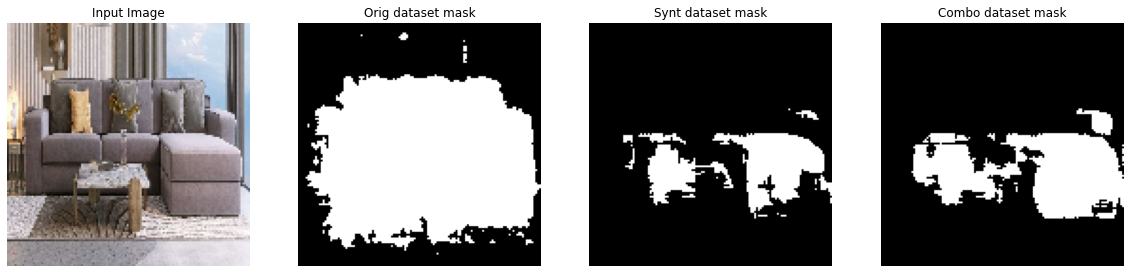

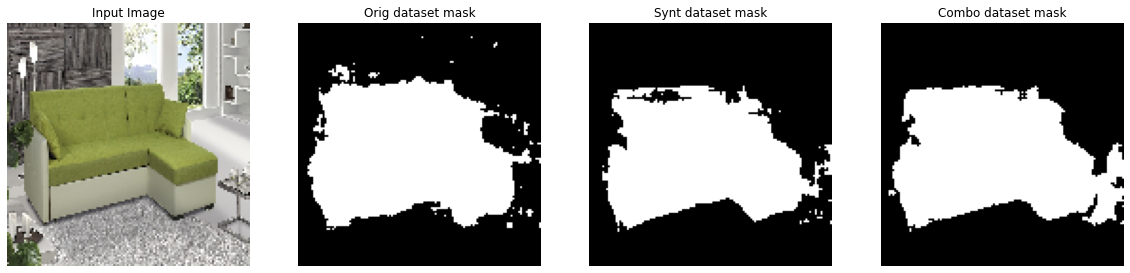

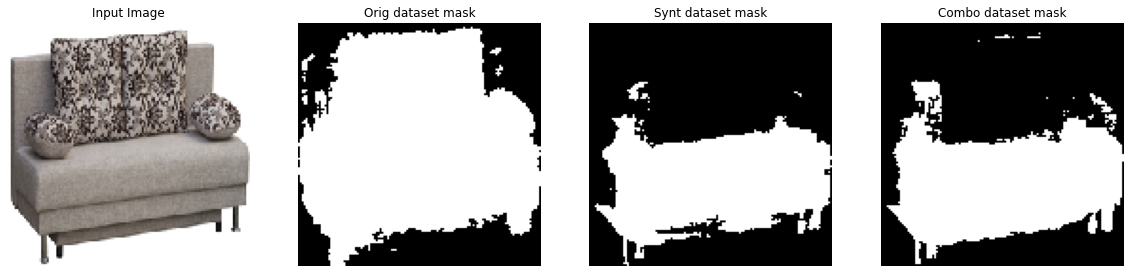

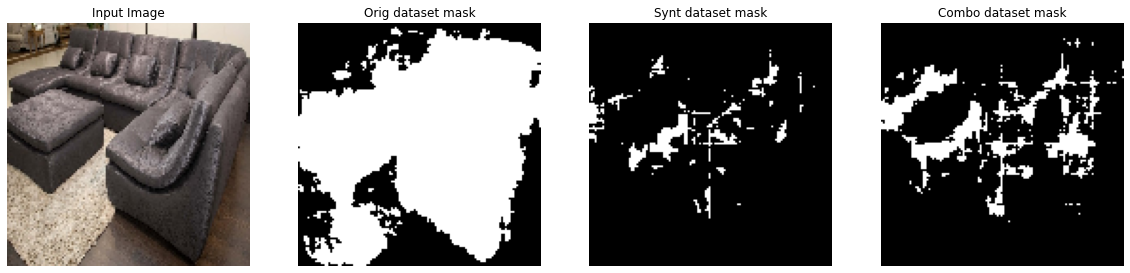

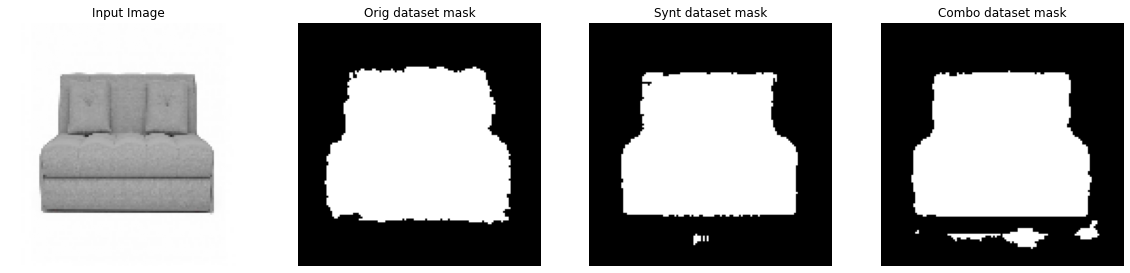

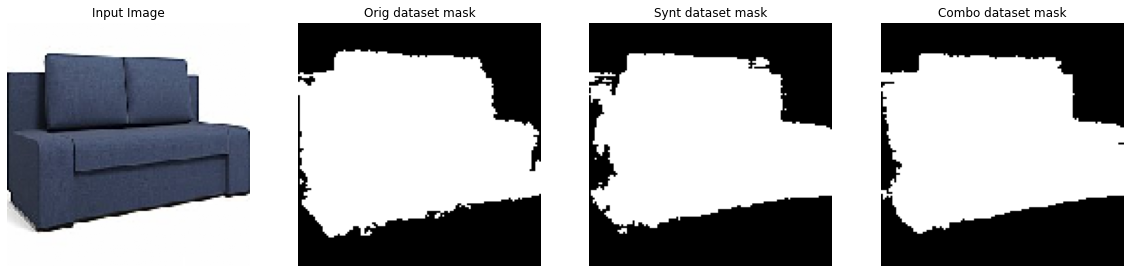

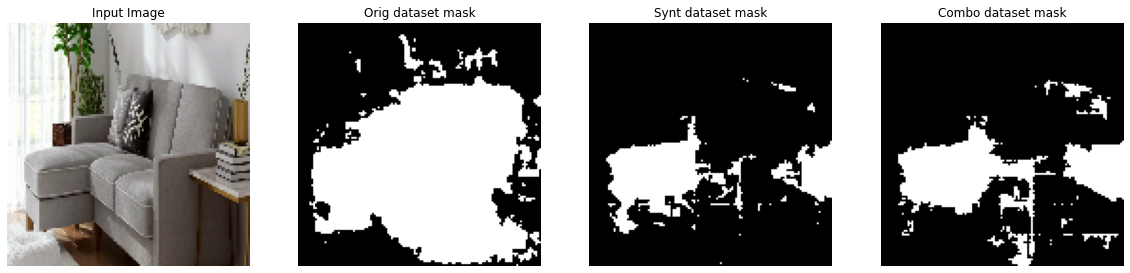

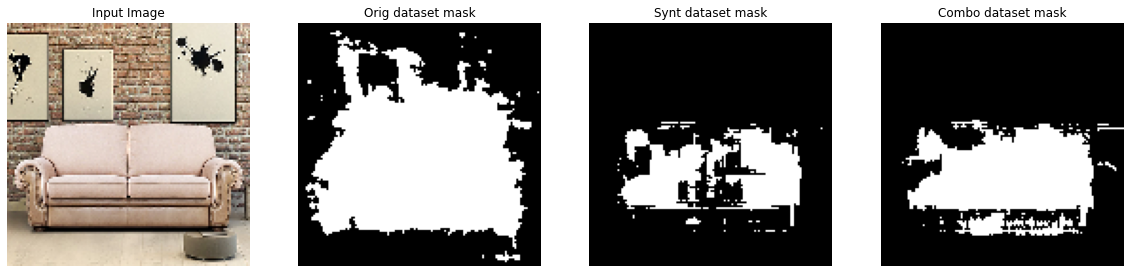

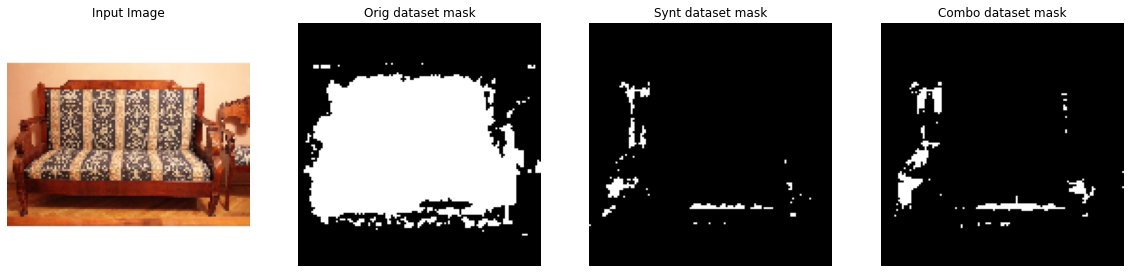

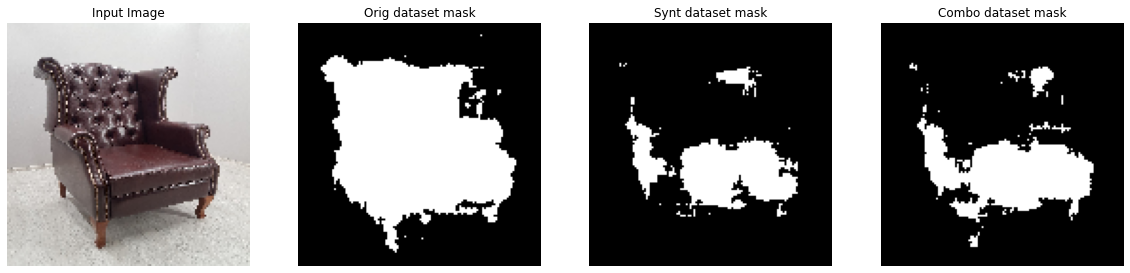

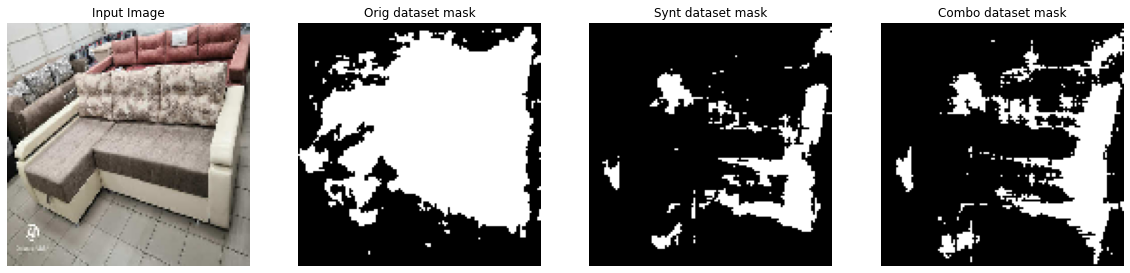

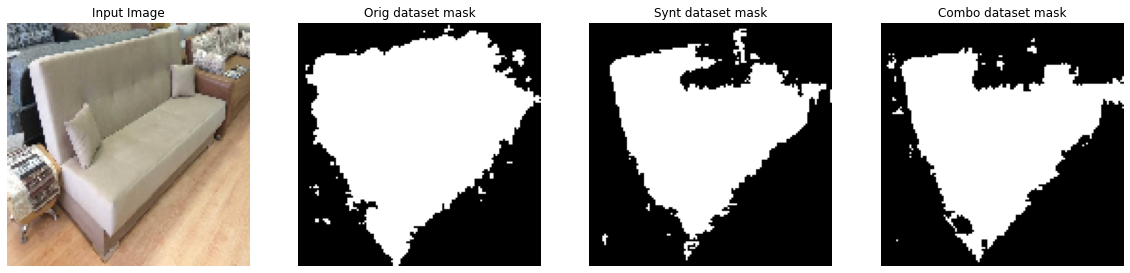

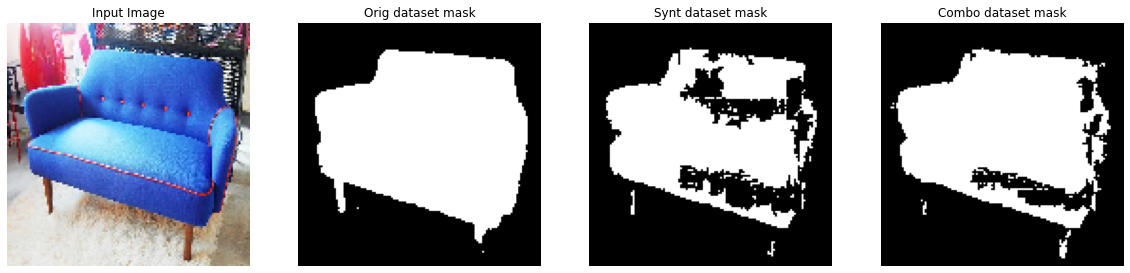

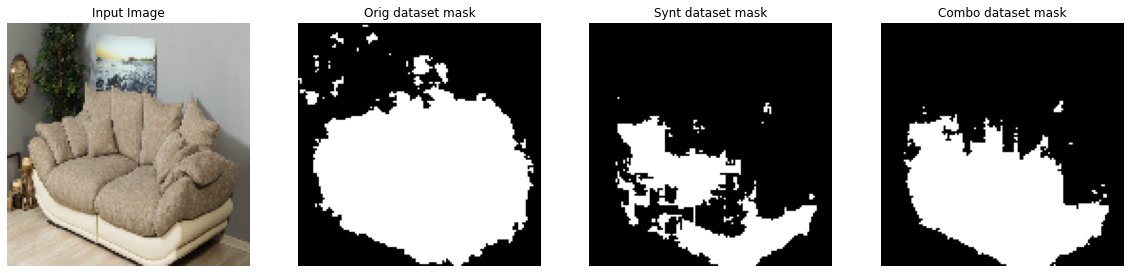

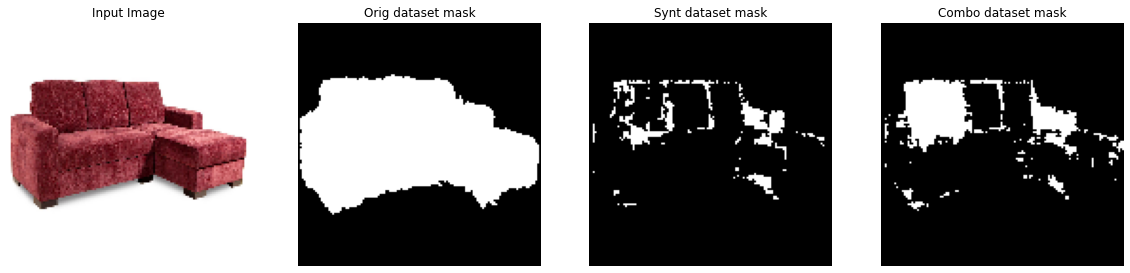

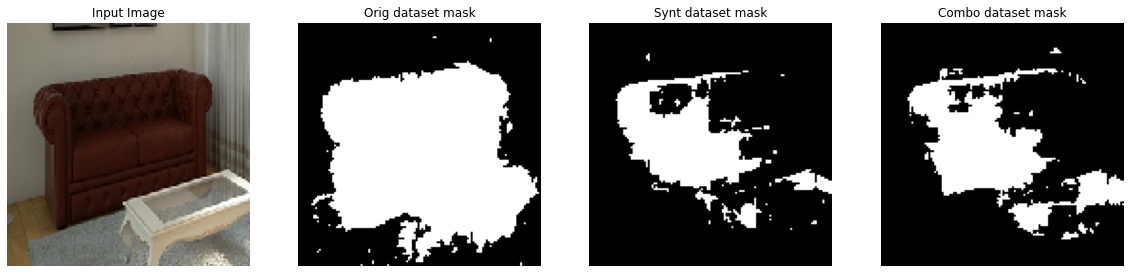

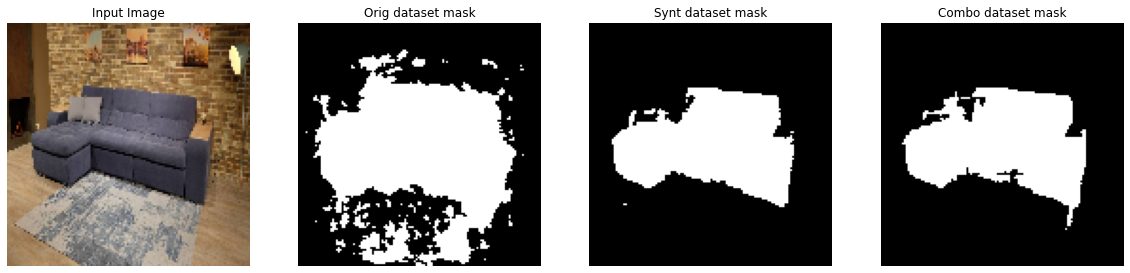

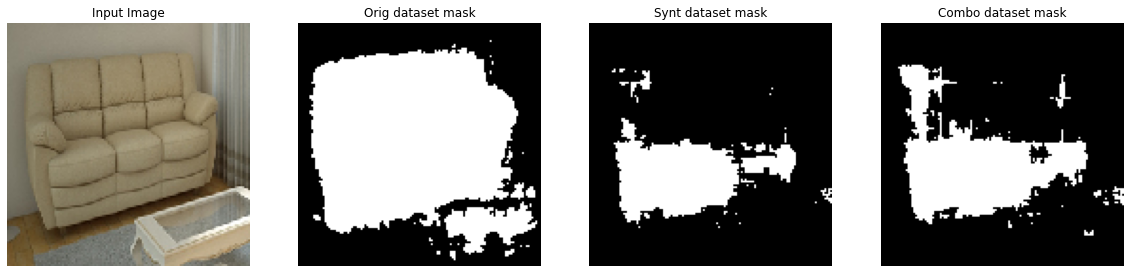

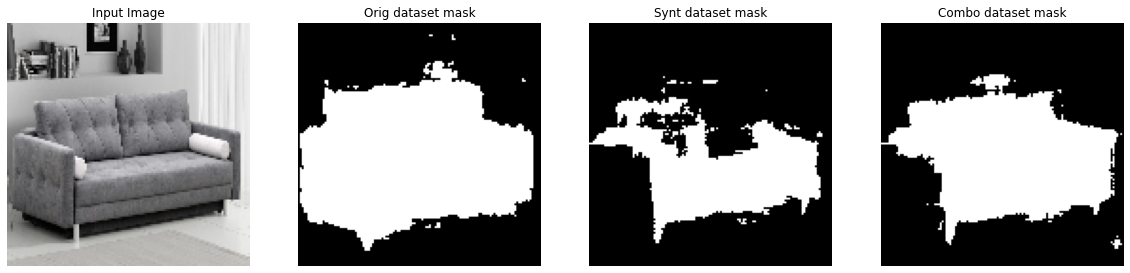

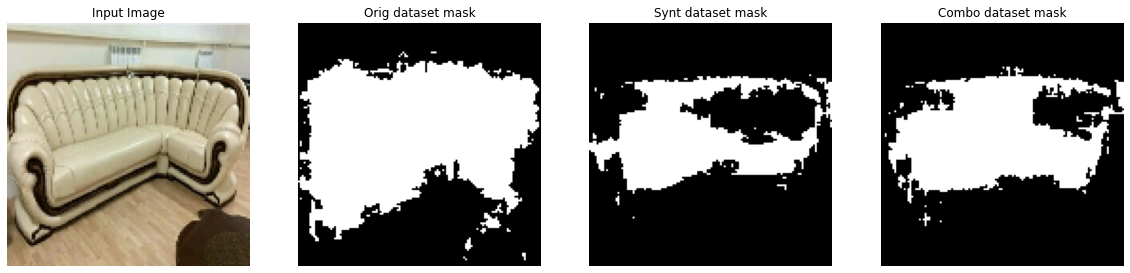

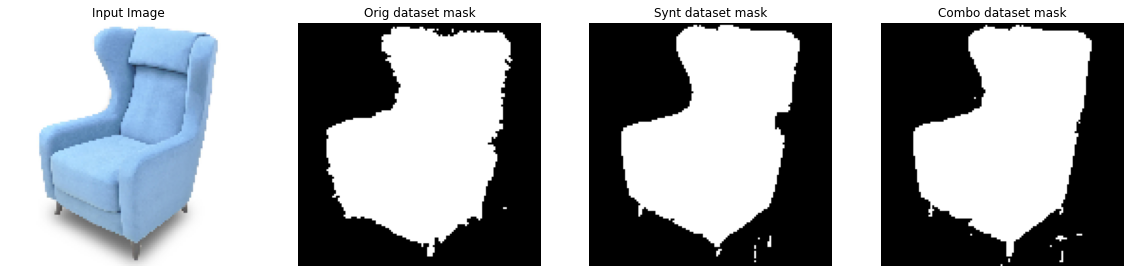

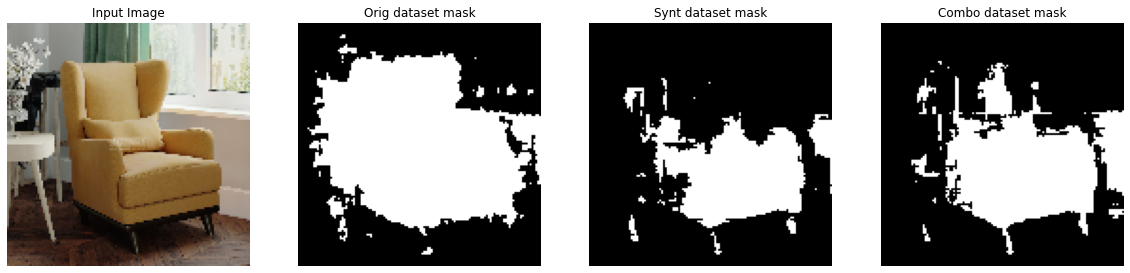

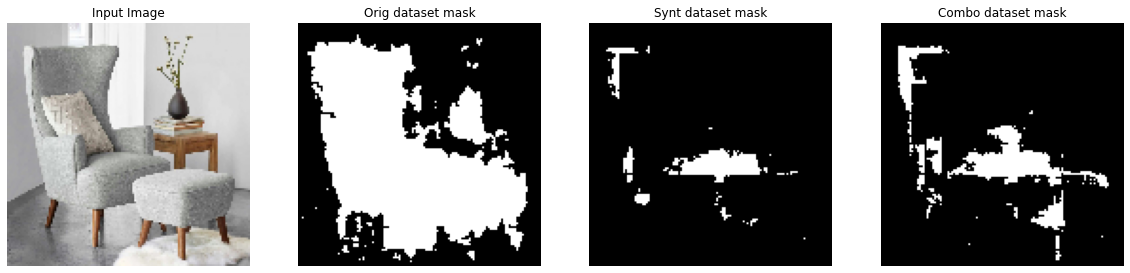

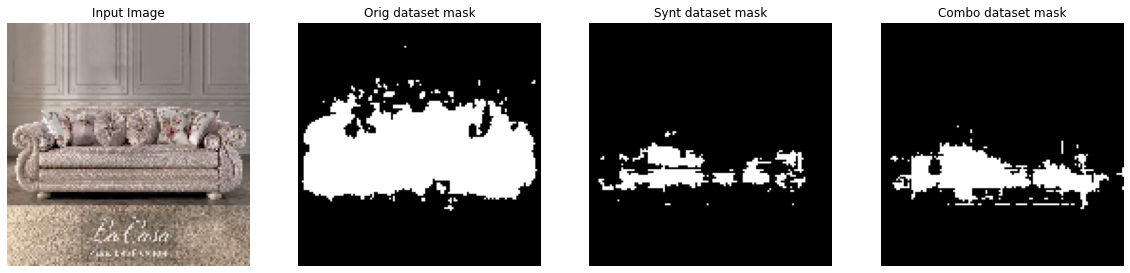

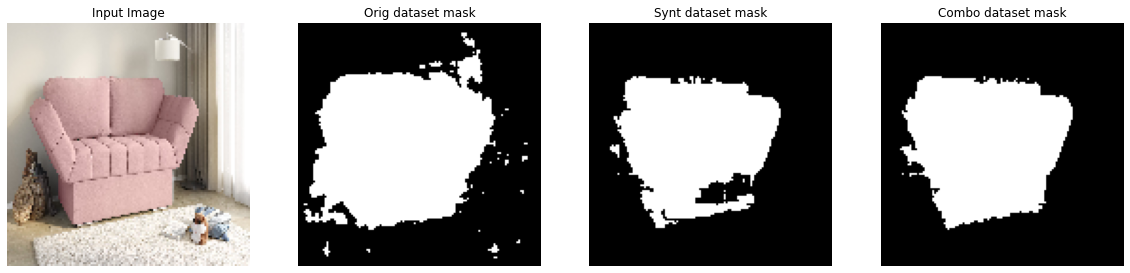

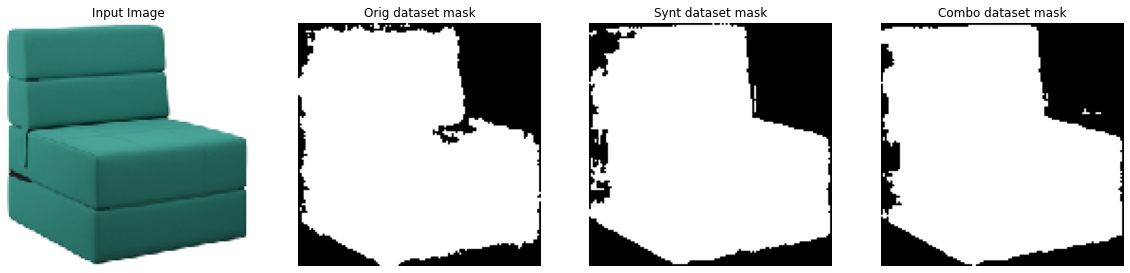

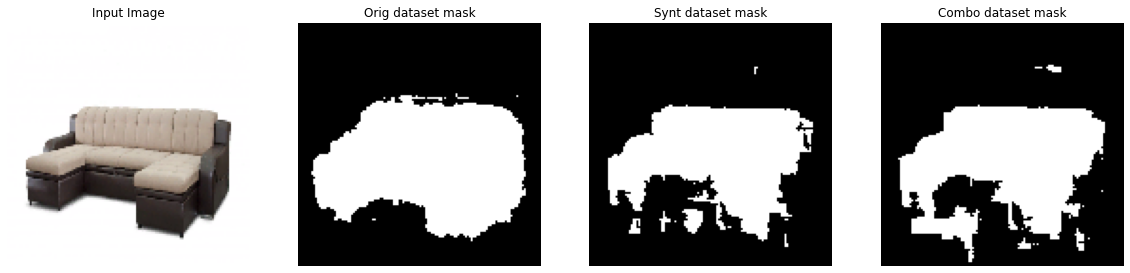

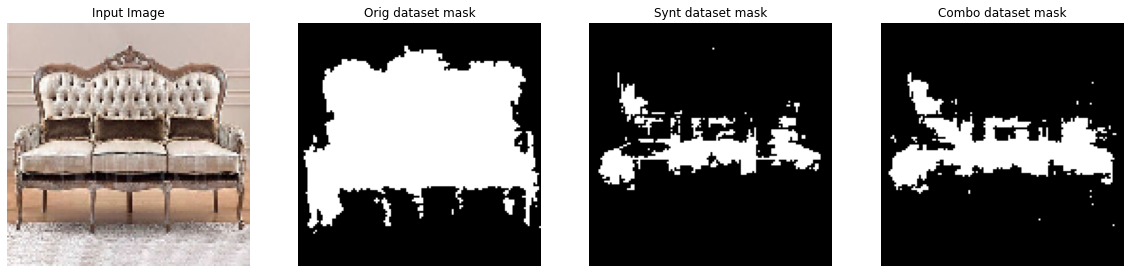

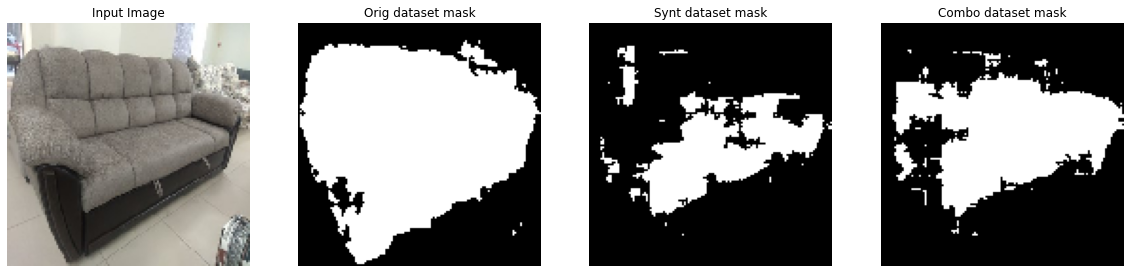

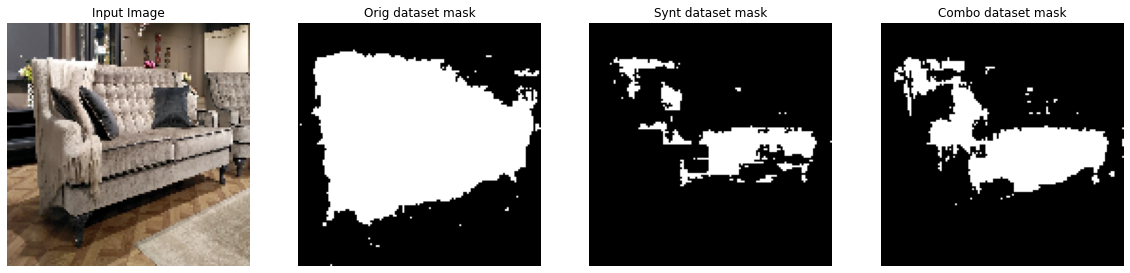

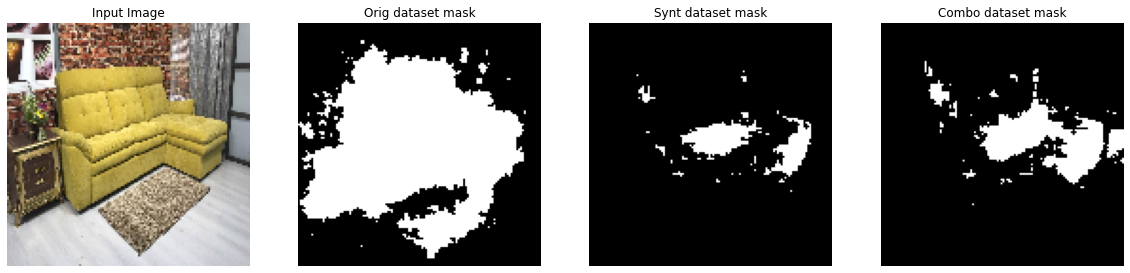

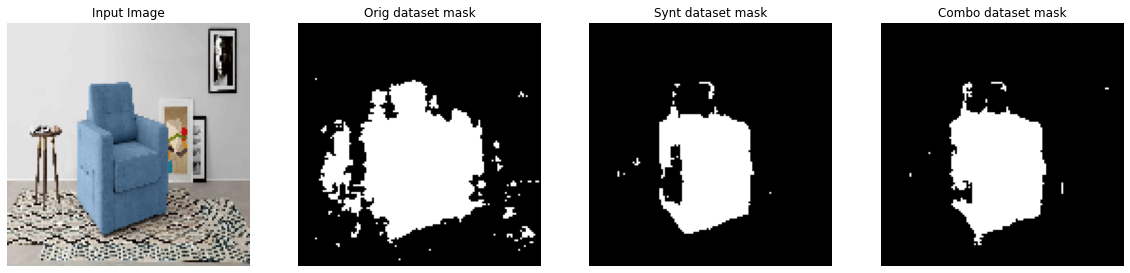

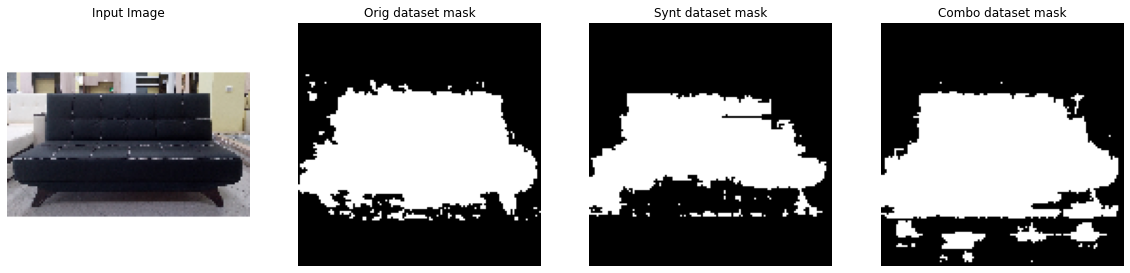

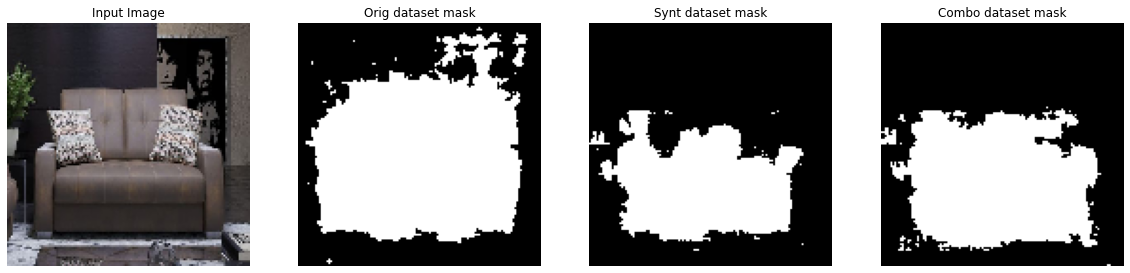

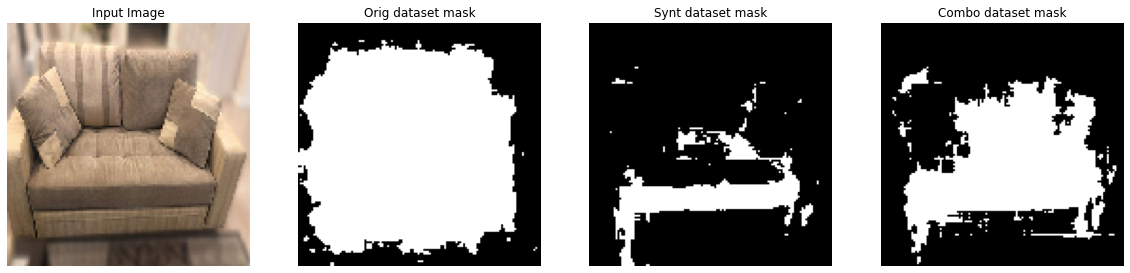

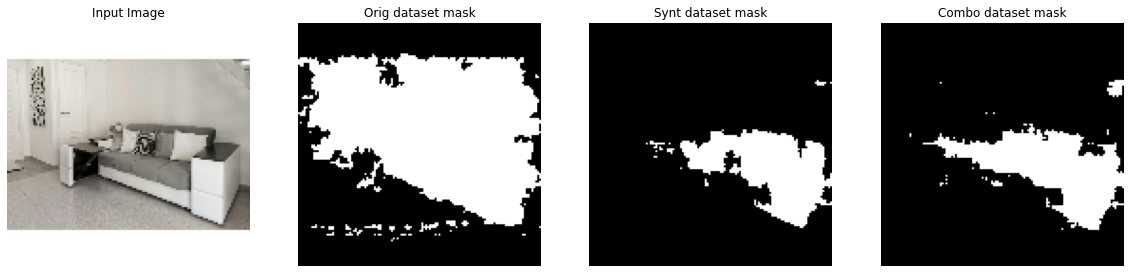

In [155]:
history = []
# plt.imshow()
# lost = [1,2,3,4,5,7,8,10,11,13,15,21]
# bad_real = [5,8,12,16,17,20,24,26,27]
# good_boost = [6,9,16,22,27]
# good_combo = [9,16,22]

# good_c_synt = [0,1,5,8]
bad_real_dual = [0,1,5,7,8]
good_dual_synt = [4,12,15]
good_dual_combo = [6,12,20]
bad_synt_cube = [2,4,6]
bad_combo_cube = [2,3,4,8,6]
for i in range(36):
#     if i not in bad_combo_cube:
#     print(i)
    g = eval_[i]
    show_fm3(g)

#     history.append(model.evaluate(g[0],g[1],steps=1,verbose=1))

In [43]:
import pandas as pd
cols = ['loss','accuracy','mean_iou','dice_coef','f1_score']
history_pd = pd.DataFrame(history, columns=cols)

In [44]:
history_pd.mean()

loss         0.015347
accuracy     0.984604
mean_iou     0.811642
dice_coef    0.807138
f1_score     0.068279
dtype: float64

In [45]:
history_pd.to_csv('cube_complete_combo.csv')

In [16]:
# history_synt = pd.read_csv('cube_complete_synt.csv',index_col=0)
# history_synt.mean()

In [17]:
# import pandas as pd
# h_real = pd.read_csv('complete_real.csv',index_col=0)
# h_synt = pd.read_csv('complete_boost.csv',index_col=0)
# h_combo = pd.read_csv('complete_combo.csv',index_col=0)

# alls = [h_real.mean().tolist(),
#         h_synt.mean().tolist(),
#         h_combo.mean().tolist()]

# alls = pd.DataFrame(alls)
# alls = alls.T

# colu = {0:'real',
#         1:'synt',
#         2:'combo'}
# inde = {
#     0:'loss',
#     1:'accuracy',
#     2:'iou',
#     3:'dice',
#     4:'f1',   
# }

# alls = alls.rename(columns=colu,index=inde)

In [1]:
# import pandas as pd
# hd_real = pd.read_csv('dual_complete_real.csv', index_col=0)
# hd_synt = pd.read_csv('dual_complete_synt.csv', index_col=0)
# hd_combo = pd.read_csv('dual_complete_combo.csv', index_col=0)

# alls_dual = [hd_real.mean().tolist(),
#              hd_synt.mean().tolist(),
#              hd_combo.mean().tolist()
#              ]

# alls_dual = pd.DataFrame(alls_dual)
# alls_dual = alls_dual.T

# colu = {0: 'real',
#         1: 'synt',
#         2: 'combo'}
# inde = {
#     0: 'loss',
#     1: 'accuracy',
#     2: 'iou',
#     3: 'dice',
#     4: 'f1',
# }

# alls_dual = alls_dual.rename(columns=colu, index=inde)

In [46]:
import pandas as pd
hc_real = pd.read_csv('cube_complete_orig.csv',index_col=0)
hc_synt = pd.read_csv('cube_complete_synt.csv',index_col=0)
hc_combo = pd.read_csv('cube_complete_combo.csv',index_col=0)

alls_cube = [hc_real.mean().tolist(),
        hc_synt.mean().tolist(),
        hc_combo.mean().tolist()
            ]

alls_cube = pd.DataFrame(alls_cube)
alls_cube = alls_cube.T

colu = {0:'real',
        1:'synt',
        2:'combo'}
inde = {
    0:'loss',
    1:'accuracy',
    2:'iou',
    3:'dice',
    4:'f1',   
}

alls_cube = alls_cube.rename(columns=colu,index=inde)
alls_cube

real      synt     combo
loss      0.037965  0.031186  0.015347
accuracy  0.961697  0.968736  0.984604
iou       0.718542  0.739256  0.811642
dice      0.651280  0.762659  0.807138
f1        0.072782  0.110167  0.068279

In [2]:
alls_dual

real      synt     combo
loss      0.026630  0.020538  0.026824
accuracy  0.973160  0.979309  0.973124
iou       0.757773  0.776121  0.825367
dice      0.752515  0.739123  0.827373
f1        0.094266  0.069923  0.147712

In [47]:
alls_cube.to_csv('alls_cube.csv')

In [19]:
# import skimage
# import skimage.io
# import os
# from tqdm.notebook import tqdm
# import numpy as np

# ImgDir = 'Cube/orig/'
# labels = os.listdir(f"{ImgDir}o_features/images/")
# len(labels)
# for l_name in tqdm(labels, total=len(labels)):
#     l_name = ImgDir + 'o_features/images/' + l_name
#     img = skimage.io.imread(l_name)
# #     img = np.uint8(img*255)
# #     print(np.unique(img))
# #     img[img < 255] = 0
# #     print(np.unique(img))
# #     break
#     skimage.io.imsave(l_name, img)
# #     print(np.unique(img))
# #     break
# #     img = np.uint8(img*255)
# #     skimage.io.imsave(l_name, img)

# # len(labels)


# # my_f = skimage.io.imread(my_img, as_gray=True)
# # my_f = np.uint8(my_f*255)
# # # my_f = np.uint8(np.where(my_f > 0.8, 255, 0))
# # plt.imshow(img)

In [43]:
eval_obj_path = 'sofa_real/'

In [45]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

def normalize_mask(input_image):
    k = 200
    input_image[input_image < k] = 0
    input_image[input_image > k] = 255
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image


eval_image_for_test = np.array([
    cv2.resize(cv2.imread(f'{eval_obj_path}/image_for_test/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    for file in tqdm(os.listdir(f'{eval_obj_path}/image_for_test/'))])

image_for_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

image_for_test_generator = image_for_test_datagen.flow_from_directory(
    f'{eval_obj_path}image_for_test_dg/',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training'
)

  0%|          | 0/37 [00:00<?, ?it/s]

Found 37 images belonging to 1 classes.


In [117]:
def get_mask(img):
#     test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
#     test_img = img.copy()
    color = 200
    
    re_img = cv2.resize(test_img.copy(),
               dsize=(IMG_HEIGHT, IMG_WIDTH),
               interpolation=cv2.INTER_CUBIC)
    
    coef_y = test_img.shape[0] / re_img.shape[0]
    coef_x = test_img.shape[1] / re_img.shape[1]

    pred = re_img / 255.
    pred = create_mask(model.predict(pred[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour[:, :, 0] = contour[:, :, 0] * coef_x
        contour[:, :, 1] = contour[:, :,  1] * coef_y

    filled_img = cv2.drawContours(test_img, [max(contours, key = cv2.contourArea)], -1, 255, 1)
    filled_img = cv2.fillPoly(test_img.copy(), pts=[max(contours, key = cv2.contourArea)], color=color,)

#     filled_img = cv2.drawContours(test_img, contours, -1, 255, 1)
#     filled_img = cv2.fillPoly(test_img.copy(), pts=contours, color=color,)

    cv2.addWeighted(test_img, 0.5, filled_img, 0.5, 0, test_img)

    box = cv2.boundingRect(max(contours, key = cv2.contourArea))
    cv2.rectangle(test_img, box, color=color,thickness=4)

    plt.figure(figsize=(10, 10))
    plt.imshow(test_img)

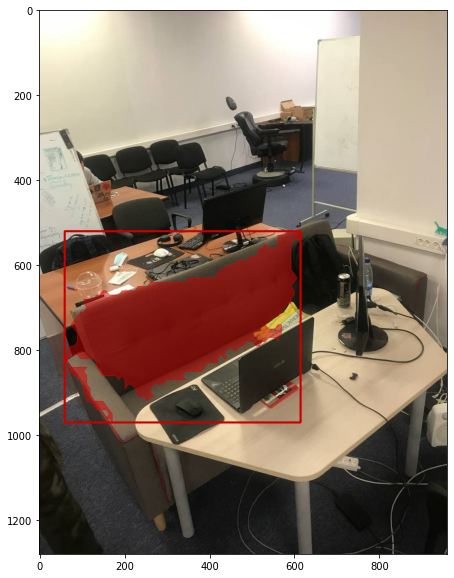

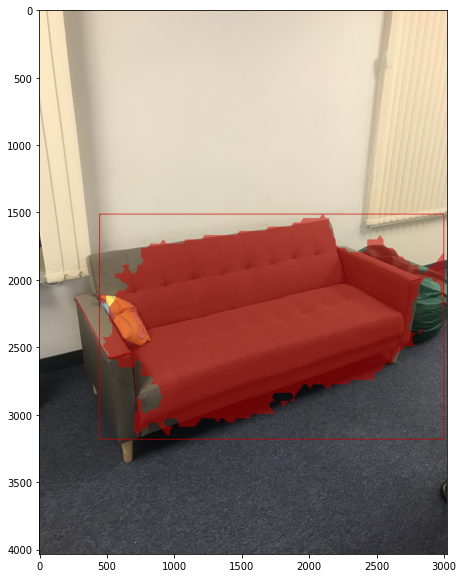

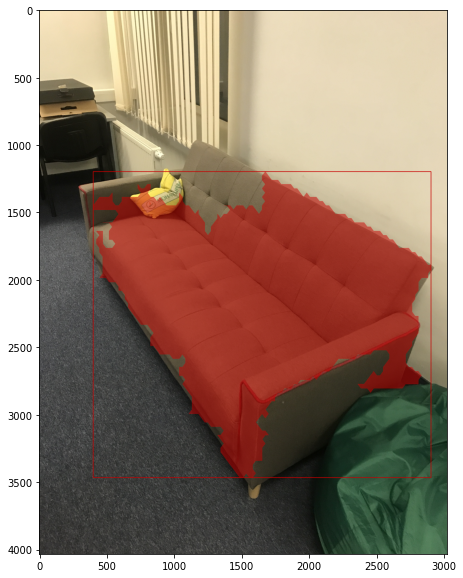

In [118]:
img_path = 'sofa_real/image_for_test/'
img_names = ['photo_2021-06-28_22-00-36.jpg',
            'IMG_0366.JPG',
            'IMG_0367.JPG'
           ]
for i in img_names:
    f_name = img_path + i
    get_mask(cv2.imread(f_name))

In [110]:
# get_mask(img_)

In [87]:
a = next(image_for_test_generator)
a[0].shape

(128, 128, 3)